# Modelo de regresión simple

A lo largo de este notebook se mostrará el código y metodología usada para la exploración, análisis y transformación del dataset, así como la construcción del modelo.


### Instalación de modulos

Se instalrán los modulos que no tenga por defecto el ambiente donde se ejecute el código puesto que este código se podrá ejecutar en distintos ambientes virtuales.

In [2]:
!pip install plotly

In [3]:
!pip install pandas

In [4]:
!pip install matplotlib

### Importando módulos

Para empezar la exploración del dataset se importarán solo los módulos necesarios para el proyecto.

In [5]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly
import re
print('Modulos importados')

modules are imported


### Dataset loading
Carguemos el dataset:

In [6]:
dataset_url = 'datos_esta.csv'
df = pd.read_csv(dataset_url)

### Exploración del dataset

Veamos los datos que contiene el dataset:

In [7]:
df.head()

,Temperatura_C,Temperatura_K,Fem_mV
0,169,442,2.149
1,170,443,2.170
2,171,444,2.193
3,172,445,2.214
4,173,446,2.238


In [8]:
df.tail()

,Temperatura_C,Temperatura_K,Fem_mV
204,391,664,11.135
205,392,665,11.206
206,393,666,11.257
207,394,667,11.321
208,395,668,11.383


In [9]:
df.shape

(209, 3)

In [10]:
df.describe()

,Temperatura_C,Temperatura_K,Fem_mV
count,209.000000,209.000000,209.000000
mean,279.846890,552.846890,5.960096
std,65.555434,65.555434,2.679898
min,169.000000,442.000000,2.149000
25%,224.000000,497.000000,3.607000
50%,279.000000,552.000000,5.573000
75%,336.000000,609.000000,8.119000
max,395.000000,668.000000,11.383000


### Visualizaciones
Con el propósito de entender mejor el comportamiento de los datos, grafiquemos las relaciones de nuestro interés.

In [11]:
column_names = list(df.columns)
print(column_names)

['Temperatura_C', 'Temperatura_K', 'Fem_mV']


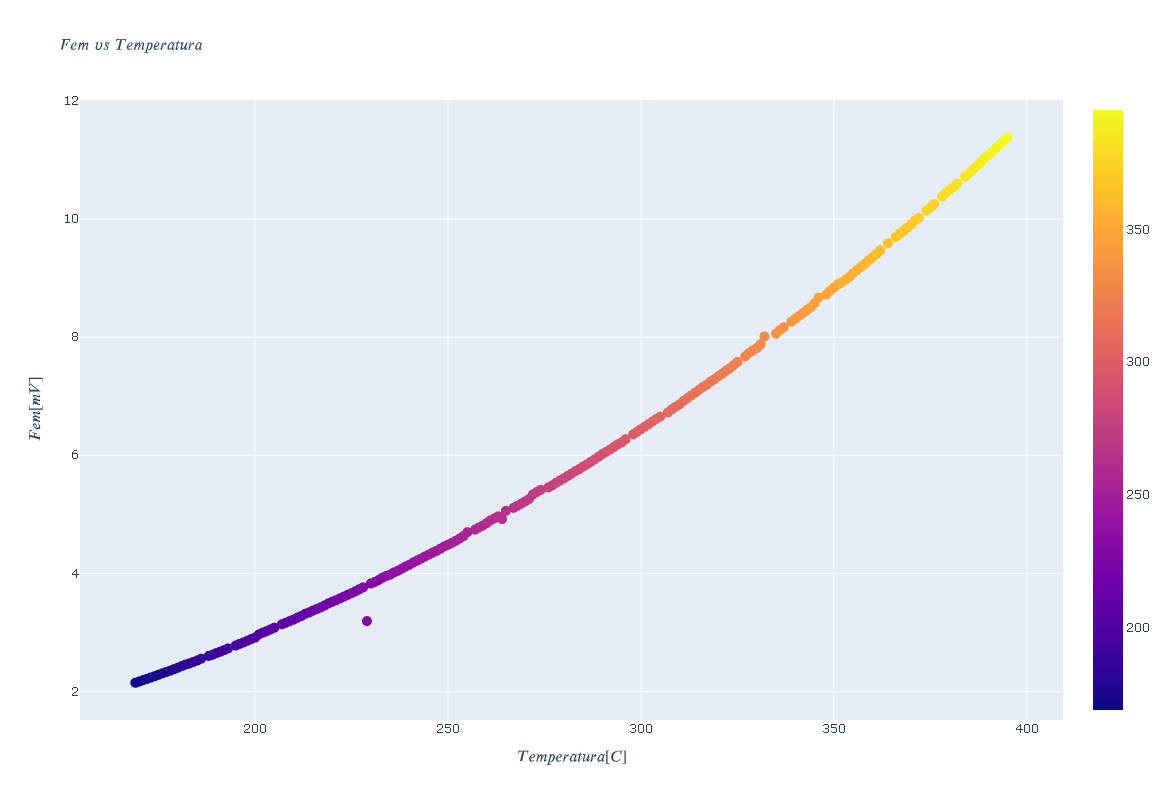

In [72]:
fig = go.Figure(
data = go.Scatter(
    x= df['Temperatura_C'],
    y = df['Fem_mV'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_C'],
    showscale = True,
    ),
    text = df['Temperatura_C']
)
)

fig.update_layout(title = r'$Fem \,\, vs \,\, Temperatura$'
                 , xaxis_title = r'$Temperatura[C]$'
                 , yaxis_title = r'$Fem[mV]$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

Debido a que nos interesa modelarlo a traveés de una regresión lineal, transformemos lsod atos de manera logarítmica, base 10, para determinar si se puede modelar linealmente.

In [13]:
df['ln_Temperatura_C'] = np.log10(df['Temperatura_C'])
df['ln_Temperatura_K'] = np.log10(df['Temperatura_K'])
df['ln_Fem'] = np.log10(df['Fem_mV'])
df.head()

,Temperatura_C,Temperatura_K,Fem_mV,ln_Temperatura_C,ln_Temperatura_K,ln_Fem
0,169,442,2.149,2.227887,2.645422,0.332236
1,170,443,2.170,2.230449,2.646404,0.336460
2,171,444,2.193,2.232996,2.647383,0.341039
3,172,445,2.214,2.235528,2.648360,0.345178
4,173,446,2.238,2.238046,2.649335,0.349860


Como nos sirven las columnas asosciadas a la escala de centigrados, eliminémoslas:

In [14]:
df.drop('Temperatura_C', axis=1)
df.drop('ln_Temperatura_C', axis=1)
df.head()

,Temperatura_C,Temperatura_K,Fem_mV,ln_Temperatura_C,ln_Temperatura_K,ln_Fem
0,169,442,2.149,2.227887,2.645422,0.332236
1,170,443,2.170,2.230449,2.646404,0.336460
2,171,444,2.193,2.232996,2.647383,0.341039
3,172,445,2.214,2.235528,2.648360,0.345178
4,173,446,2.238,2.238046,2.649335,0.349860


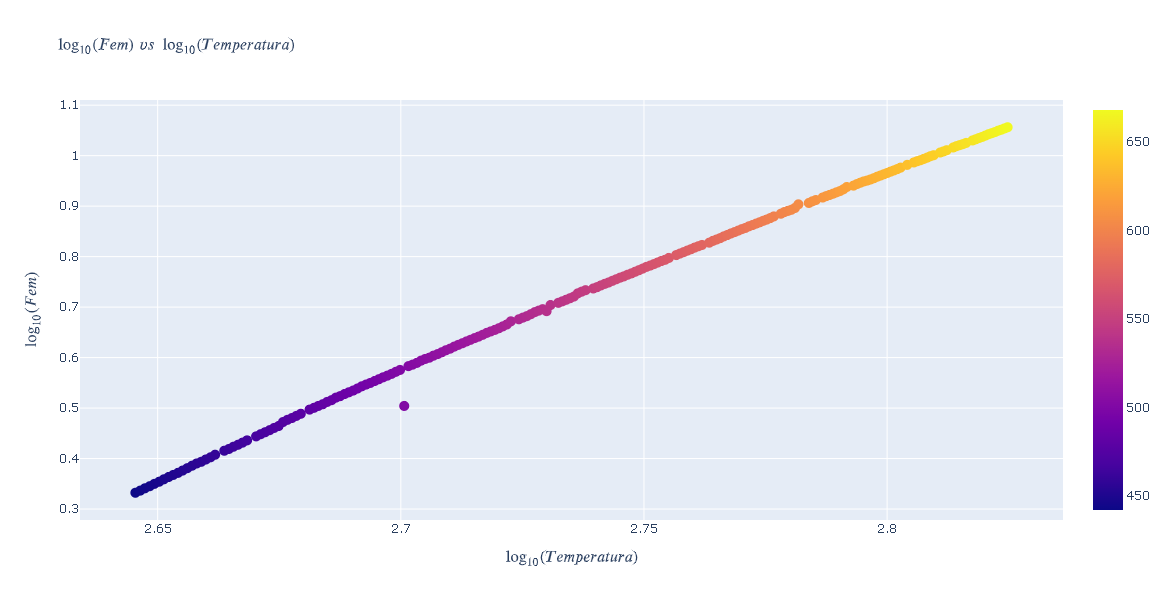

In [69]:
fig = go.Figure(
data = go.Scatter(
    x= df['ln_Temperatura_K'],
    y = df['ln_Fem'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_K'],
    showscale = True,
    ),
    text = df['Temperatura_K']
)
)

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura)$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=600)
fig.show()

### Creación del modelo

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
from sklearn.linear_model import LinearRegression

Indiquemos las imágenes del dataframe con la que se contruirán el modleo: X variable independiente, y variable dependiente.

In [16]:
X = df.iloc[:, -2:-1].values
y = df.iloc[:, -1].values

Verifiquemos que los conjuntos sean los deseados:

In [17]:
print(X[0:5])
print(y[0:5])

[[2.64542227]
 [2.64640373]
 [2.64738297]
 [2.64836001]
 [2.64933486]]
[0.33223642 0.33645973 0.34103863 0.34517762 0.34986008]


Contruyamos el conjunto de entrenamiento y de testeo con la partición usual de 80-20:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

In [34]:
X_train.shape

(167, 1)

In [38]:
X_train.flatten()

array([2.74193908, 2.77158748, 2.64933486, 2.71516736, 2.76789762,
       2.68930886, 2.70586371, 2.74507479, 2.67209786, 2.73957234,
       2.7930916 , 2.81756537, 2.65321251, 2.68574174, 2.7458552 ,
       2.75966784, 2.76192784, 2.7466342 , 2.8122447 , 2.74429298,
       2.71683772, 2.70415052, 2.67024585, 2.67577834, 2.70329138,
       2.69983773, 2.78103694, 2.72835378, 2.66464198, 2.78532984,
       2.76342799, 2.69810055, 2.79448805, 2.69548168, 2.80413943,
       2.77305469, 2.74350976, 2.77011529, 2.74741181, 2.80550086,
       2.7355989 , 2.77887447, 2.65896484, 2.67302091, 2.74818803,
       2.80955971, 2.66558099, 2.69108149, 2.79795964, 2.82216808,
       2.77378644, 2.70500796, 2.64738297, 2.70243054, 2.82151353,
       2.81491318, 2.68841982, 2.65513843, 2.79098848, 2.71432976,
       2.81954394, 2.82085799, 2.80753503, 2.78031731, 2.7363965 ,
       2.64836001, 2.73239376, 2.75739603, 2.78958071, 2.81888541,
       2.6946052 , 2.74896286, 2.64542227, 2.73319727, 2.76863

Contruyamos el modelo

In [21]:
regression = LinearRegression()

In [22]:
regression.fit(X_train, y_train)
reg = regression.fit(X_train, y_train)

In [23]:
y_pred = regression.predict(X_test)

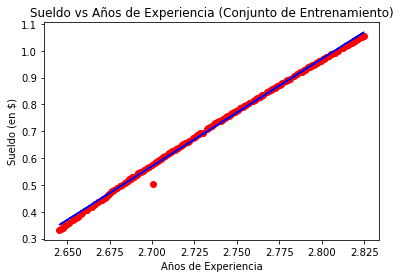

In [24]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, regression.predict(X_train), color = "blue")
plt.title("Sueldo vs Años de Experiencia (Conjunto de Entrenamiento)")
plt.xlabel("Años de Experiencia")
plt.ylabel("Sueldo (en $)")
plt.show()

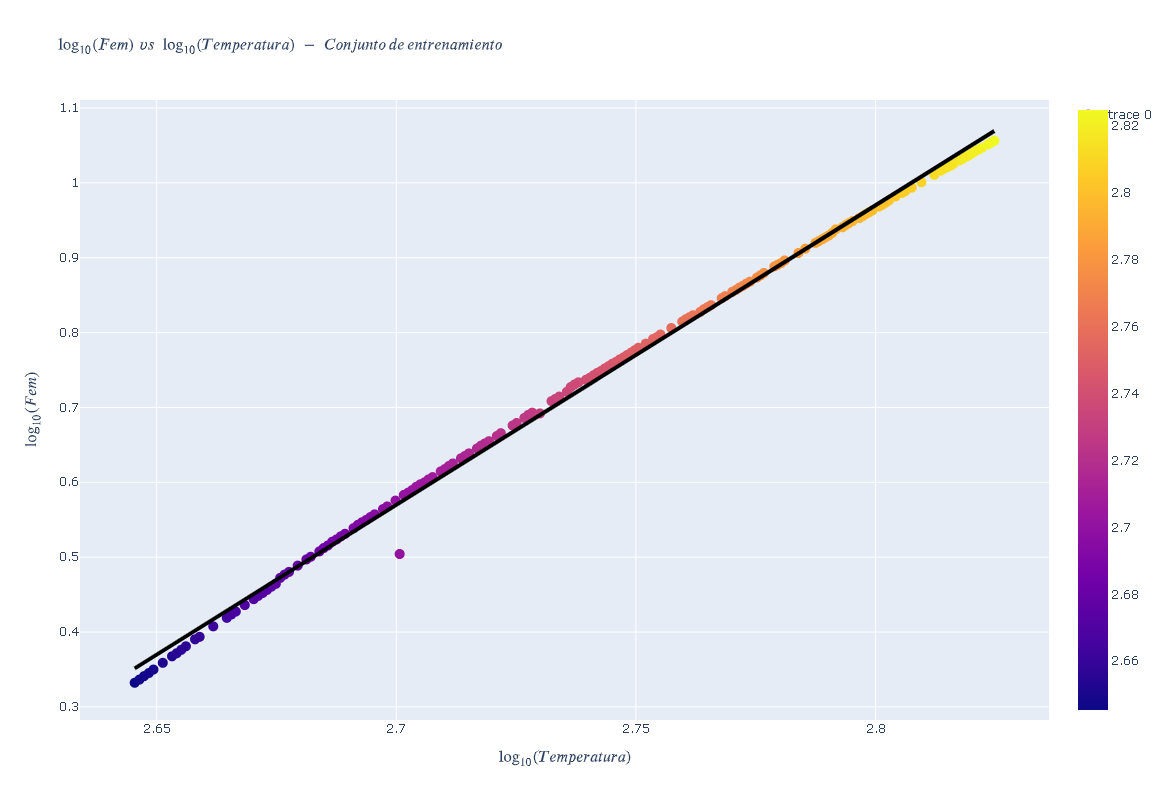

In [78]:
fig = go.Figure(
data = go.Scatter(
    x = X_train.flatten(),
    y = y_train.flatten(),
    mode = 'markers',
    marker = dict(
    size = 10,
    color = X_train.flatten(),
    showscale = True,
    ),
    text = X_train
)
)

fig.add_trace(go.Scatter(x=X_train.flatten(), y=regression.predict(X_train).flatten(),
                    mode='lines',
                    #line=go.scatter.Line(color="Black"),
                    line=dict(color="black",
                              width=4),
                    showlegend=False))

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura) \,\, - \,\, Conjunto \, de \, entrenamiento$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

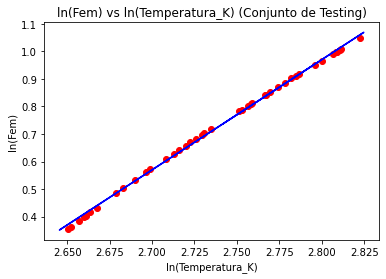

In [25]:
plt.scatter(X_test, y_test, color = "red")
plt.plot(X_train, regression.predict(X_train), color = "blue")
plt.title("ln(Fem) vs ln(Temperatura_K) (Conjunto de Testing)")
plt.xlabel("ln(Temperatura_K)")
plt.ylabel("ln(Fem)")
plt.show()

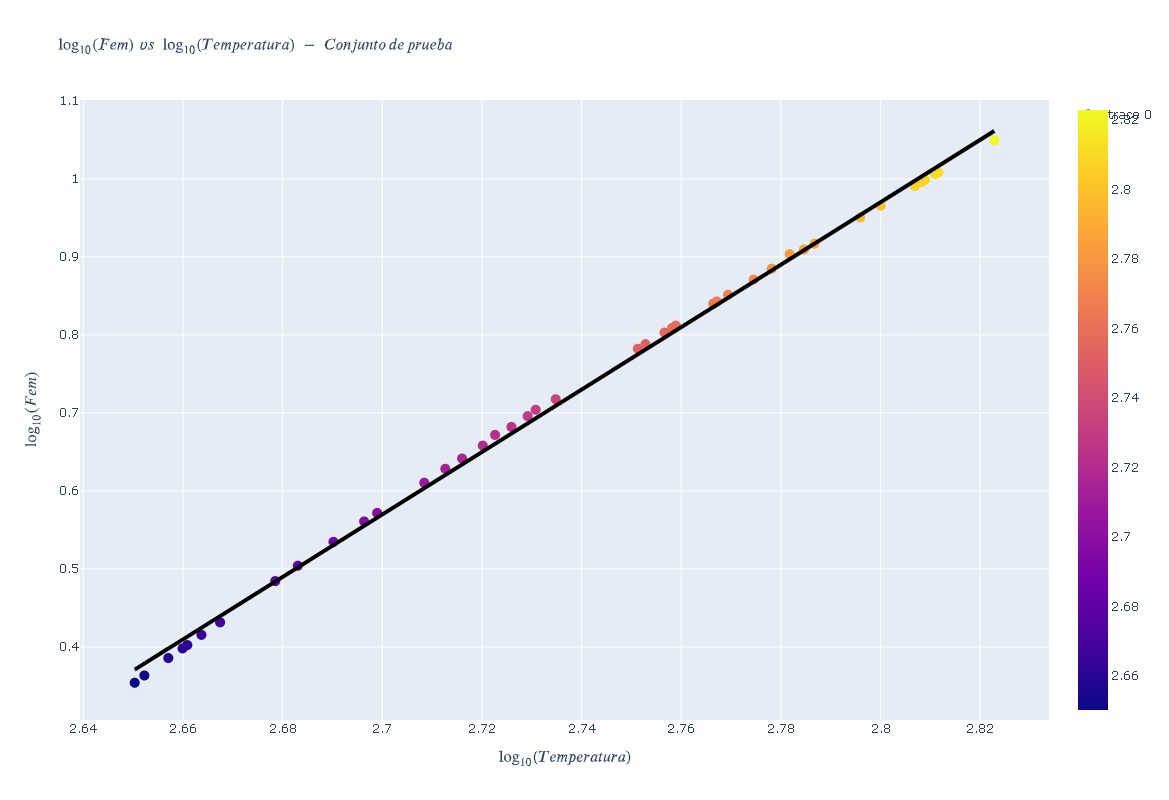

In [77]:
fig = go.Figure(
data = go.Scatter(
    x = X_test.flatten(),
    y = y_test.flatten(),
    mode = 'markers',
    marker = dict(
    size = 10,
    color = X_test.flatten(),
    showscale = True,
    ),
    text = X_test
)
)

fig.add_trace(go.Scatter(x=X_test.flatten(), y=regression.predict(X_test).flatten(),
                    mode='lines',
                    #line=go.scatter.Line(color="Black"),
                    line=dict(color="black",
                              width=4),
                    showlegend=False))

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura) \,\, - \,\, Conjunto \, de \, prueba$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

In [26]:
print(reg.coef_)
print(reg.intercept_)

[4.00246208]
-10.236829393605635


In [27]:
reg.score(X, y)

0.9980572767097294

Debido a que existe la posibilidad de que el conjunto de entrenamiento haya tan particual que la regresión es buena, apliquemos validación curzada para reducir dicha posibilidad y mostrar que para distintos conjuntos de entrenamiento se obtendrán resultados similares:

In [28]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = reg, X = X_train, y = y_train, cv = 10)
print("La media es: " + str(accuracies.mean()))
print("La desviación estandar es: " + str(accuracies.std()))

La media es: 0.997831196799917
La desviación estandar es: 0.002071969923855275


Si deseamos ver el array de los coeficientes de determinación:

In [29]:
accuracies

array([0.99808313, 0.9986294 , 0.99883242, 0.99822115, 0.99811459,
       0.99851464, 0.99174797, 0.99958194, 0.99817059, 0.99841614])

Vemos que la media de los coeficientes de determinación es muy cercana a uno y la desviación estándar, a cero; por lo que podemos concluir que para cualquier conjunto de entrenamiento se obtendrán resultados similares.

Recordemos que se aplico un escalamiento logarítmico base 10, por lo que el modelo final es de la forma:
$$
P(T) = B\alpha T^c
$$

con $\alpha$ la constante de Boltzmann. Ahora obtengamos las constantes necesarias para definir nuestro modelo:

In [30]:
Ba = 10**reg.intercept_
print(Ba)
c = reg.coef_
print(c)

5.7965636144242e-11
[4.00246208]


Por lo tanto, considerando que las cifras siginificativas dadas por la precisión de los intrumentos de medición es del orden $10^{-3}mV$, entonces  la función analítica es:

$$
P(T) = 5.796 \times 10^{-11} T ^{4.002} mW
$$

Notemos que la cosntante $B\alpha$ es del orden de $10^{-11}$ porque la $Fem$ está mediada en $[mV]$ y no en $[V]$. Por lo que al escalarla a la misma dimensión física, queda del orden deseado.